# 5. Extension

In [1]:
import sys
import numpy as np
import cv2
import torch
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import previous notebook
import nbimporter
import Task2 as Note2
import Task1AE as Note1AE
import Task1FG as Note1FG

import math
from typing import Any

import torch
from torch.nn import Parameter
from torch.nn.modules import Conv2d, Module


# 1. Replace the first layer of the MNIST network with a filter bank of your choosing (e.g. Gabor filters) and retrain the rest of the network, holding the first layer constant. How does it do?

In [2]:
# 1. get gabor from opencv
filters = []
ksize = 10
for theta in np.arange(0, np.pi, np.pi / 16):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    filters.append(kern)
    
# 2. convert to np then to torch object
gabor_arr = np.array(filters)
print(gabor_arr.shape)
gabor_torch = torch.from_numpy(gabor_arr)
print(gabor_torch.shape)

(16, 11, 11)
torch.Size([16, 11, 11])


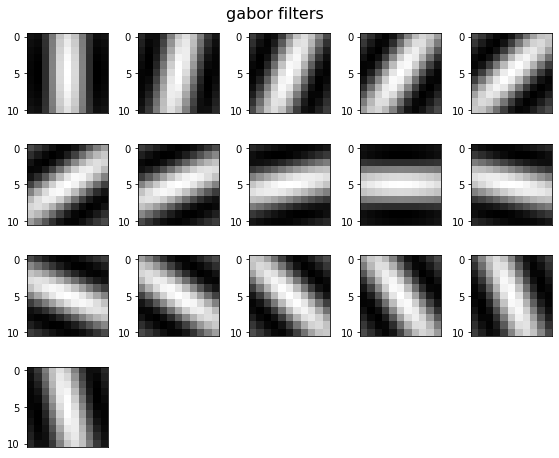

In [3]:
# 3. plot the filter
figure = plt.figure(figsize=(8, 8))
for i in range(16):
    
    # 1. Prepare grid
    plt.subplot(5, 5, i+1)
    plt.tight_layout()

    # 2. make sure the shape is 10X10 before doing imshow
    # print("shape", gabor_arr[i].shape)

    # 3. show
    figure.suptitle("gabor filters", fontsize=16)
    plt.imshow(gabor_arr[i],  cmap="gray", interpolation="none")
    plt.xticks([])

In [45]:

class GaborConv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        self.is_calculated = False

        self.conv_layer = Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        self.kernel_size = self.conv_layer.kernel_size

        # small addition to avoid division by zero
        self.delta = 1e-3

        # freq, theta, sigma are set up according to S. Meshgini,
        # A. Aghagolzadeh and H. Seyedarabi, "Face recognition using
        # Gabor filter bank, kernel principal component analysis
        # and support vector machine"
        self.freq = Parameter(
            (math.pi / 2)
            * math.sqrt(2)
            ** (-torch.randint(0, 5, (out_channels, in_channels))).type(torch.Tensor),
            requires_grad=True,
        )
        self.theta = Parameter(
            (math.pi / 8)
            * torch.randint(0, 8, (out_channels, in_channels)).type(torch.Tensor),
            requires_grad=True,
        )
        self.sigma = Parameter(math.pi / self.freq, requires_grad=True)
        self.psi = Parameter(
            math.pi * torch.rand(out_channels, in_channels), requires_grad=True
        )

        self.x0 = Parameter(
            torch.ceil(torch.Tensor([self.kernel_size[0] / 2]))[0], requires_grad=False
        )
        self.y0 = Parameter(
            torch.ceil(torch.Tensor([self.kernel_size[1] / 2]))[0], requires_grad=False
        )

        self.y, self.x = torch.meshgrid(
            [
                torch.linspace(-self.x0 + 1, self.x0 + 0, self.kernel_size[0]),
                torch.linspace(-self.y0 + 1, self.y0 + 0, self.kernel_size[1]),
            ]
        )
        self.y = Parameter(self.y)
        self.x = Parameter(self.x)

        self.weight = Parameter(
            torch.empty(self.conv_layer.weight.shape, requires_grad=True),
            requires_grad=True,
        )

        self.register_parameter("freq", self.freq)
        self.register_parameter("theta", self.theta)
        self.register_parameter("sigma", self.sigma)
        self.register_parameter("psi", self.psi)
        self.register_parameter("x_shape", self.x0)
        self.register_parameter("y_shape", self.y0)
        self.register_parameter("y_grid", self.y)
        self.register_parameter("x_grid", self.x)
        self.register_parameter("weight", self.weight)

    def forward(self, input_tensor):
        if self.training:
            self.calculate_weights()
            self.is_calculated = False
        if not self.training:
            if not self.is_calculated:
                self.calculate_weights()
                self.is_calculated = True
        return self.conv_layer(input_tensor)

    def calculate_weights(self):
        for i in range(self.conv_layer.out_channels):
            for j in range(self.conv_layer.in_channels):
                sigma = self.sigma[i, j].expand_as(self.y)
                freq = self.freq[i, j].expand_as(self.y)
                theta = self.theta[i, j].expand_as(self.y)
                psi = self.psi[i, j].expand_as(self.y)

                rotx = self.x * torch.cos(theta) + self.y * torch.sin(theta)
                roty = -self.x * torch.sin(theta) + self.y * torch.cos(theta)

                g = torch.exp(
                    -0.5 * ((rotx ** 2 + roty ** 2) / (sigma + self.delta) ** 2)
                )
                g = g * torch.cos(freq * rotx + psi)
                g = g / (2 * math.pi * sigma ** 2)
                self.conv_layer.weight.data[i, j] = g

    def _forward_unimplemented(self, *inputs: Any):
        """
        code checkers makes implement this method,
        looks like error in PyTorch
        """
        raise NotImplementedError

In [46]:
# in channel, out channel, size
layer = GaborConv2d(1, 1, (5, 5))
print(layer)

GaborConv2d(
  (conv_layer): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [51]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        # call the parent constructor
        super(NeuralNetwork, self).__init__()
        
        #1. CNN
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        self.conv1 = GaborConv2d(1, 10, (10, 10))
        print(self.conv1)
        
        # final output : 20 Channels X 4 X 4
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # default is 0.5 or half
        
        #2. ANN
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(50, 10)
        
        self.flatten = nn.Flatten()
     

    def forward(self, x):
        # 1. first conv, max pool, relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # 2. 2nd conv, droptout layer, max pool, relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # 3. reshape tensor . Question: why to -1, 320. this is same as flatten
        x = x.view(-1, 320)
        
        # 4. fully connected, relu
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        # 5. convert the output from a Linear layer
        # into a categorical probability distribution
        return F.log_softmax(x, -1)

In [52]:
network = NeuralNetwork()

GaborConv2d(
  (conv_layer): Conv2d(1, 10, kernel_size=(10, 10), stride=(1, 1), bias=False)
)


image shape: torch.Size([1, 28, 28])
torch.Size([10, 19, 19])
weights shape torch.Size([10, 1, 10, 10])
shape (10, 10)
[[0.0000000e+00 0.0000000e+00           nan           nan 0.0000000e+00
  0.0000000e+00           nan           nan           nan           nan]
 [1.4012985e-45 0.0000000e+00           nan           nan           nan
            nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan
            nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan
            nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan
            nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan
            nan           nan           nan           nan           nan]
 [         

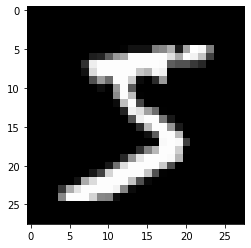

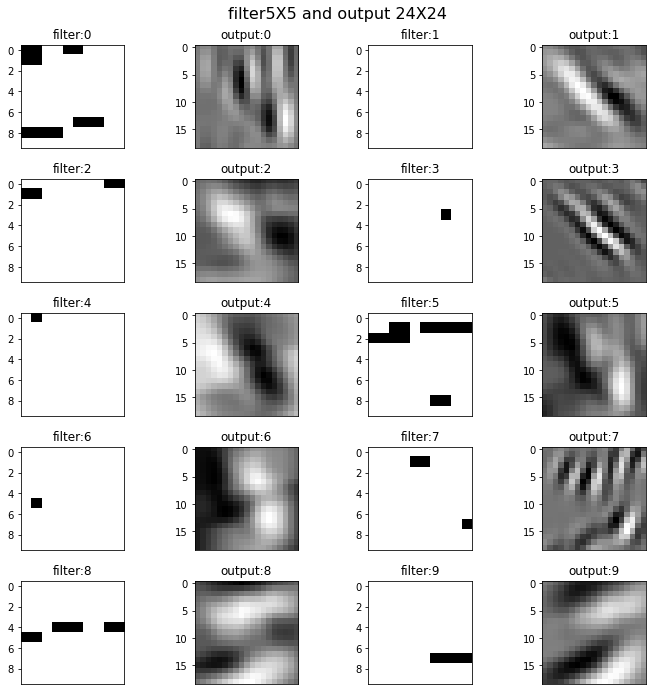

In [53]:
# plot filter and result
train_loader = Note1AE.get_loader(is_train=True)
img = Note1FG.load_firstN_data(train_loader, 1)[0]
print("image shape:", img.shape)
plt.imshow(img[0], cmap='gray', interpolation='none')

# 1. apply first conv filter to the image
with torch.no_grad():
    network.eval()
    output = network.conv1(img)
    print(output.shape)
    
# 2. plot
figure = plt.figure(figsize=(10, 10))
img_index = 0
plot_index = 1 # total 20 plots
figure.suptitle("filter5X5 and output 24X24", fontsize=16)

weights = network.conv1.weight
print("weights shape", weights.shape)
while(img_index < 10):
        # - draw filter
        plt.subplot(5, 4, plot_index)
        plt.tight_layout()
        filter_matrix = weights[img_index][0].detach().numpy()
        print("shape", filter_matrix.shape)
        print(filter_matrix)
        plt.imshow(filter_matrix, cmap = 'gray', interpolation="none")
        plt.title("filter:%d" %(img_index))
        plt.xticks([])

        plot_index+=1

        # - draw output after filter
        plt.subplot(5, 4, plot_index)
        plt.tight_layout()
        output_matrix = output[img_index]
        plt.title("output:%d" %(img_index))

        plt.imshow(output_matrix, cmap='gray',interpolation="none")
        plt.xticks([])

        img_index +=1
        plot_index+=1   

# 2. Evaluate more dimensions on task 3

# 3. Explore a different computer vision task with available data.